# Post-tuning the decision threshold for cost-sensitive learning

Once a classifier is trained, the output of the predict method outputs class label predictions corresponding to a thresholding of either the decision_function or the predict_proba output. For a binary classifier, the default threshold is defined as a posterior probability estimate of 0.5 or a decision score of 0.0.

However, this default strategy is most likely not optimal for the task at hand. Here, we use the “Statlog” German credit dataset [1] to illustrate a use case. In this dataset, the task is to predict whether a person has a “good” or “bad” credit. In addition, a cost-matrix is provided that specifies the cost of misclassification. Specifically, misclassifying a “bad” credit as “good” is five times more costly on average than misclassifying a “good” credit as “bad”.

We use the TunedThresholdClassifierCV to select the cut-off point of the decision function that minimizes the provided business cost.


# Section 1 : Cost-sensitive learning with constant gains and costs

we illustrate the use of the TunedThresholdClassifierCV in a setting of cost-sensitive learning when the gains and costs associated to each entry of the confusion matrix are constant.

# 1. Load the required dataset and perform EDA

In [70]:
import sklearn
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np


sklearn.set_config(transform_output="pandas")

german_credit = fetch_openml(data_id=31, as_frame=True, parser="pandas")
X, y = german_credit.data, german_credit.target

In [72]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [74]:
X.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [80]:
y.value_counts()

,count
class,
good,700
bad,300


In [81]:
pos_label, neg_label = "bad", "good"

# 2. Data preparation for modelling

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# 3. Define the helper functions associated with Evaluation metrics

In [84]:
from sklearn.metrics import confusion_matrix


def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

In [85]:
from sklearn.metrics import make_scorer, precision_score, recall_score

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

We define a python function that weight the confusion matrix and return the overall cost.

We call a “business metric” any metric function that aims at quantifying how the predictions (correct or wrong) might impact the business value of deploying a given machine learning model in a specific application context. For our credit prediction task, the authors provide a custom cost-matrix which encodes that classifying a a “bad” credit as “good” is 5 times more costly on average than the opposite: it is less costly for the financing institution to not grant a credit to a potential customer that will not default (and therefore miss a good customer that would have otherwise both reimbursed the credit and payed interests) than to grant a credit to a customer that will default.

In [86]:
import numpy as np


def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    # The rows of the confusion matrix hold the counts of observed classes
    # while the columns hold counts of predicted classes. Recall that here we
    # consider "bad" as the positive class (second row and column).
    # Scikit-learn model selection tools expect that we follow a convention
    # that "higher" means "better", hence the following gain matrix assigns
    # negative gains (costs) to the two kinds of prediction errors:
    # - a gain of -1 for each false positive ("good" credit labeled as "bad"),
    # - a gain of -5 for each false negative ("bad" credit labeled as "good"),
    # The true positives and true negatives are assigned null gains in this
    # metric.
    #
    # Note that theoretically, given that our model is calibrated and our data
    # set representative and large enough, we do not need to tune the
    # threshold, but can safely set it to the cost ration 1/5, as stated by Eq.
    # (2) in Elkan paper [2]_.
    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


scoring["cost_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label
)

# 4. Model building and evaluation

We use HistGradientBoostingClassifier as a predictive model that natively handles categorical features and missing values.

# a. Baseline predictive model

In [87]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    categorical_features="from_dtype", random_state=0
).fit(X_train, y_train)
model

HistGradientBoostingClassifier(categorical_features='from_dtype',
                               random_state=0)

evaluate the performance of our predictive model using the ROC and Precision-Recall curves

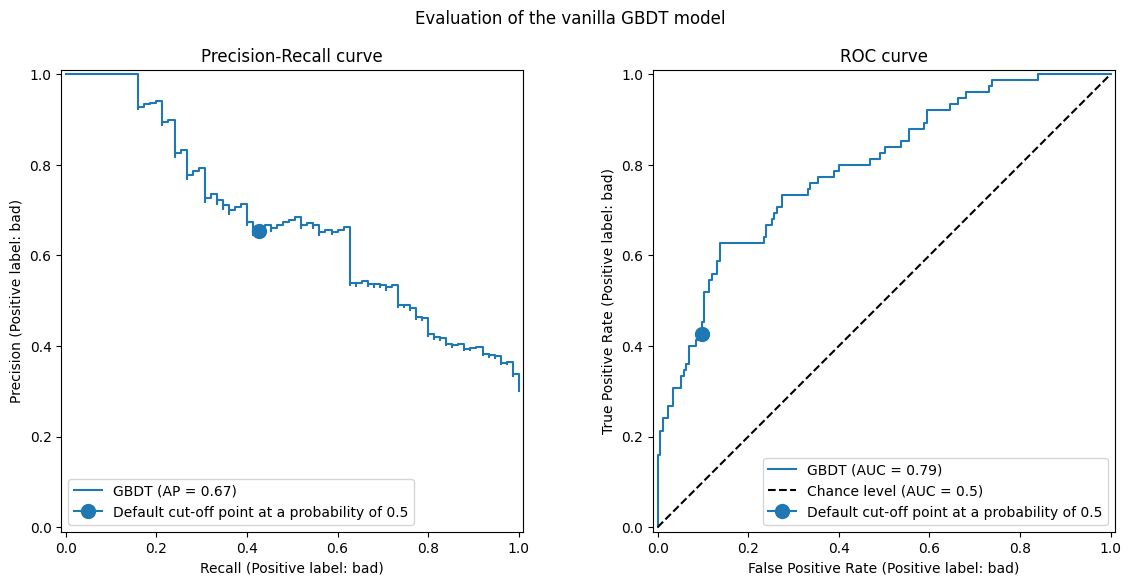

In [88]:
import matplotlib.pyplot as plt

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, pos_label=pos_label, ax=axs[0], name="GBDT"
)
axs[0].plot(
    scoring["recall"](model, X_test, y_test),
    scoring["precision"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=pos_label,
    ax=axs[1],
    name="GBDT",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](model, X_test, y_test),
    scoring["tpr"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the vanilla GBDT model")

these curves give insights on the statistical performance of the predictive model for different cut-off points. For the Precision-Recall curve, the reported metrics are the precision and recall and for the ROC curve, the reported metrics are the TPR (same as recall) and FPR.

Here, the different cut-off points correspond to different levels of posterior probability estimates ranging between 0 and 1. By default, model.predict uses a cut-off point at a probability estimate of 0.5. The metrics for such a cut-off point are reported with the blue dot on the curves: it corresponds to the statistical performance of the model when using model.predict.

original aim was to minimize the cost (or maximize the gain) as defined by the business metric. We can compute the value of the business metric :

In [89]:
print(f"Business defined metric: {scoring['cost_gain'](model, X_test, y_test)}")

Business defined metric: -232


At this stage we don’t know if any other cut-off can lead to a greater gain. To find the optimal one, we need to compute the cost-gain using the business metric for all possible cut-off points and choose the best. This strategy can be quite tedious to implement by hand, but the TunedThresholdClassifierCV class is here to help us. It automatically computes the cost-gain for all possible cut-off points and optimizes for the scoring.

# b. Tuning the cut-off point

In [90]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.02


We plot the ROC and Precision-Recall curves for the vanilla model and the tuned model. Also we plot the cut-off points that would be used by each model.

In [91]:
def plot_roc_pr_curves(vanilla_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla GBDT", "Tuned GBDT")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

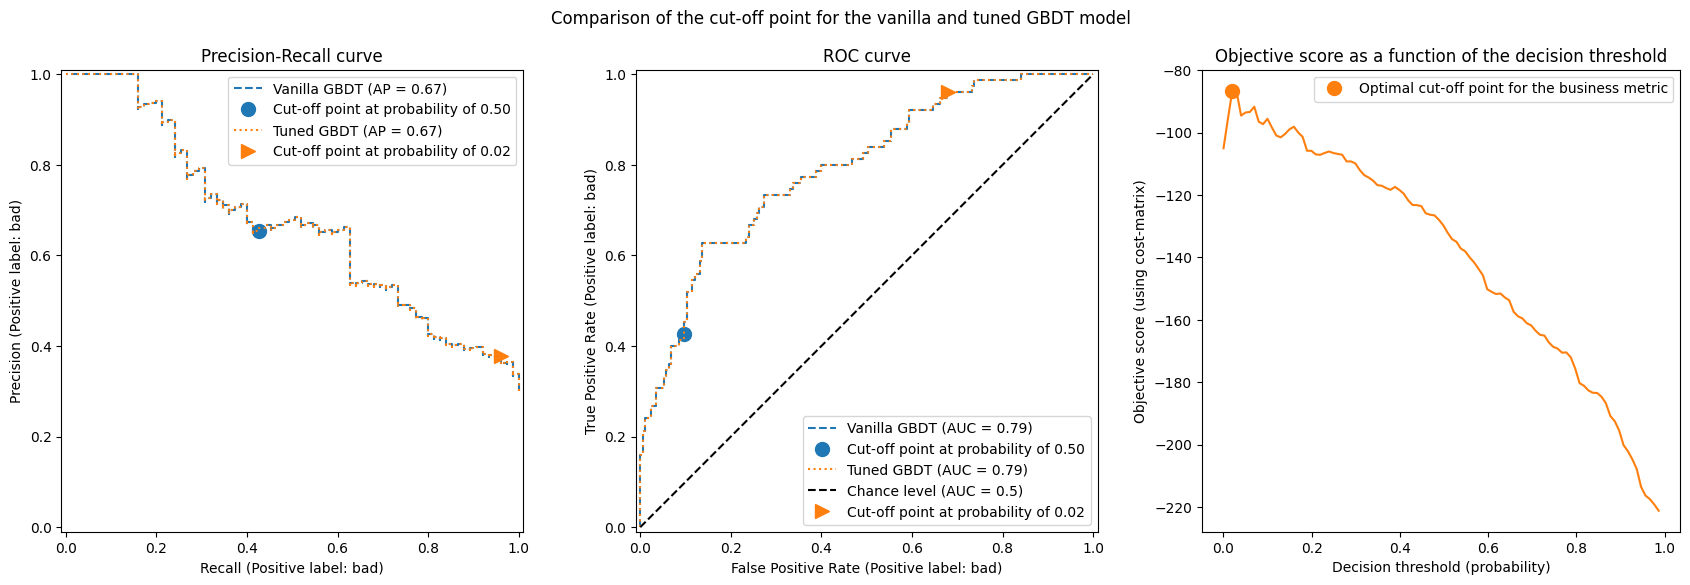

In [92]:
title = "Comparison of the cut-off point for the vanilla and tuned GBDT model"
plot_roc_pr_curves(model, tuned_model, title=title)

both classifiers have exactly the same ROC and Precision-Recall curves. It is expected because by default, the classifier is fitted on the same training data. In a later section, we discuss more in detail the available options regarding model refitting and cross-validation.

the cut-off points of the vanilla and tuned model are different. To understand why the tuned model has chosen this cut-off point, we can look at the right-hand side plot that plots the objective score that is our exactly the same as our business metric. We see that the optimum threshold corresponds to the maximum of the objective score. This maximum is reached for a decision threshold much lower than 0.5: the tuned model enjoys a much higher recall at the cost of of significantly lower precision: the tuned model is much more eager to predict the “bad” class label to larger fraction of individuals.

 check if choosing this cut-off point leads to a better score on the testing set

In [93]:
print(f"Business defined metric: {scoring['cost_gain'](tuned_model, X_test, y_test)}")

Business defined metric: -134


We observe that tuning the decision threshold almost improves our business gains by factor of 2

# c. Consideration regarding model refitting and cross-validation

In the above experiment, we used the default setting of the TunedThresholdClassifierCV. In particular, the cut-off point is tuned using a 5-fold stratified cross-validation. Also, the underlying predictive model is refitted on the entire training data once the cut-off point is chosen.

These two strategies can be changed by providing the refit and cv parameters. For instance, one could provide a fitted estimator and set cv="prefit", in which case the cut-off point is found on the entire dataset provided at fitting time. Also, the underlying classifier is not be refitted by setting refit=False. Here, we can try to do such experiment.

In [94]:
model.fit(X_train, y_train)
tuned_model.set_params(cv="prefit", refit=False).fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.28


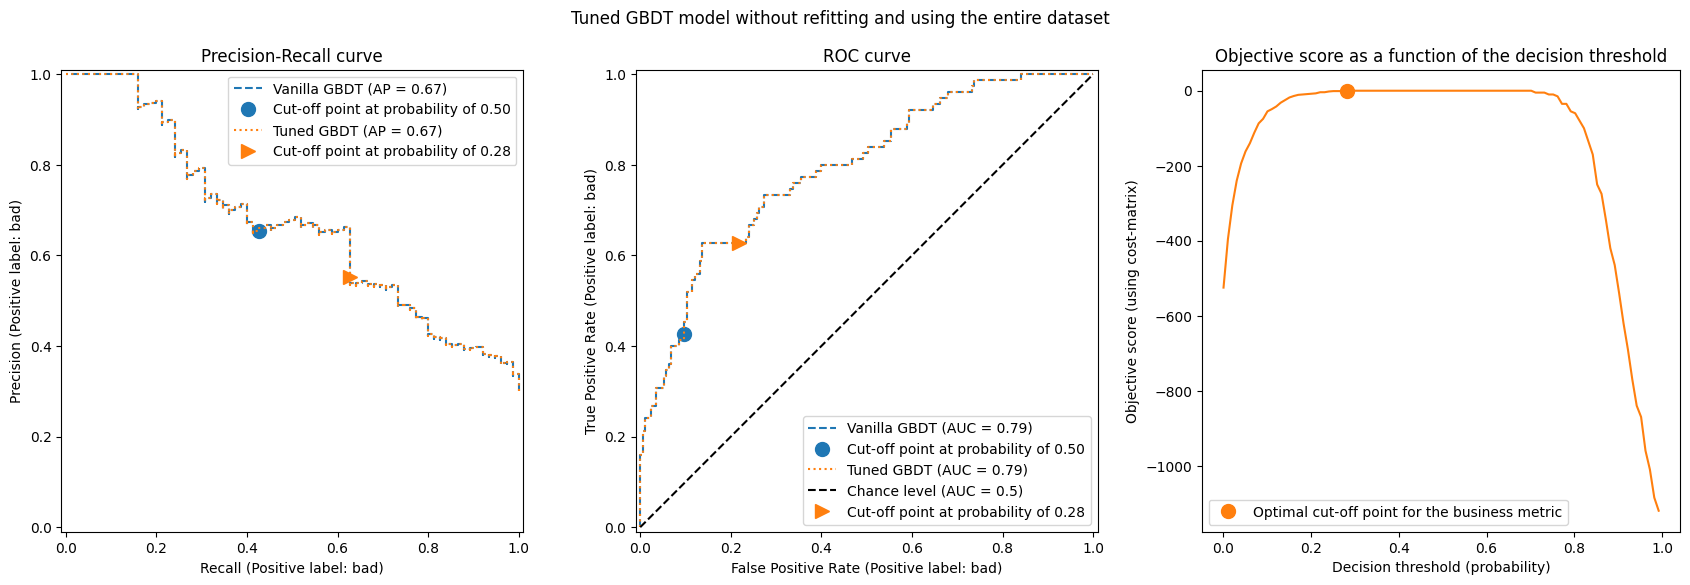

In [95]:
title = "Tuned GBDT model without refitting and using the entire dataset"
plot_roc_pr_curves(model, tuned_model, title=title)

We observe the that the optimum cut-off point is different from the one found in the previous experiment. If we look at the right-hand side plot, we observe that the business gain has large plateau of near-optimal 0 gain for a large span of decision thresholds. This behavior is symptomatic of an overfitting. Because we disable cross-validation, we tuned the cut-off point on the same set as the model was trained on, and this is the reason for the observed overfitting.

This option should therefore be used with caution. One needs to make sure that the data provided at fitting time to the TunedThresholdClassifierCV is not the same as the data used to train the underlying classifier. This could happen sometimes when the idea is just to tune the predictive model on a completely new validation set without a costly complete refit.

When cross-validation is too costly, a potential alternative is to use a single train-test split by providing a floating number in range [0, 1] to the cv parameter. It splits the data into a training and testing set. Let’s explore this option:

In [96]:
tuned_model.set_params(cv=0.75).fit(X_train, y_train)

TunedThresholdClassifierCV(cv=0.75,
                           estimator=HistGradientBoostingClassifier(categorical_features='from_dtype',
                                                                    random_state=0),
                           refit=False,
                           scoring=make_scorer(credit_gain_score, response_method='predict', neg_label=good, pos_label=bad),
                           store_cv_results=True)

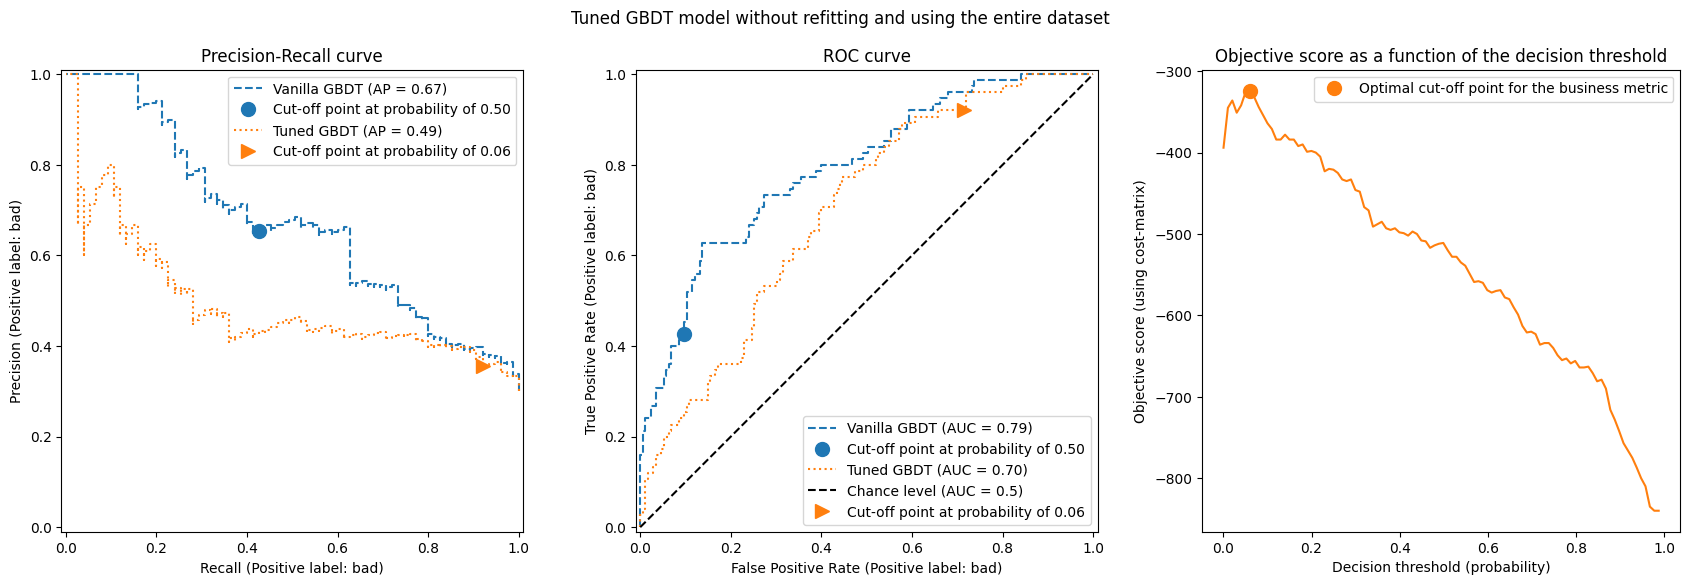

In [97]:
title = "Tuned GBDT model without refitting and using the entire dataset"
plot_roc_pr_curves(model, tuned_model, title=title)

Regarding the cut-off point, we observe that the optimum is similar to the multiple repeated cross-validation case. However, be aware that a single split does not account for the variability of the fit/predict process and thus we are unable to know if there is any variance in the cut-off point. The repeated cross-validation averages out this effect.

Another observation concerns the ROC and Precision-Recall curves of the tuned model. As expected, these curves differ from those of the vanilla model, given that we trained the underlying classifier on a subset of the data provided during fitting and reserved a validation set for tuning the cut-off point.

# Section 2 : Cost-sensitive learning when gains and costs are not constant

In [98]:
credit_card = fetch_openml(data_id=1597, as_frame=True, parser="pandas")
credit_card.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   V1      284807 non-null  float64 
 1   V2      284807 non-null  float64 
 2   V3      284807 non-null  float64 
 3   V4      284807 non-null  float64 
 4   V5      284807 non-null  float64 
 5   V6      284807 non-null  float64 
 6   V7      284807 non-null  float64 
 7   V8      284807 non-null  float64 
 8   V9      284807 non-null  float64 
 9   V10     284807 non-null  float64 
 10  V11     284807 non-null  float64 
 11  V12     284807 non-null  float64 
 12  V13     284807 non-null  float64 
 13  V14     284807 non-null  float64 
 14  V15     284807 non-null  float64 
 15  V16     284807 non-null  float64 
 16  V17     284807 non-null  float64 
 17  V18     284807 non-null  float64 
 18  V19     284807 non-null  float64 
 19  V20     284807 non-null  float64 
 20  V21     284807 non-null  f

In [99]:
columns_to_drop = ["Class"]
data = credit_card.frame.drop(columns=columns_to_drop)
target = credit_card.frame["Class"].astype(int)

In [102]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [103]:
target.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [104]:
target.value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


The dataset is highly imbalanced with fraudulent transaction representing only 0.17% of the data. Since we are interested in training a machine learning model, we should also make sure that we have enough samples in the minority class to train the model.

In [106]:
target.value_counts()

,count
Class,
0,284315
1,492


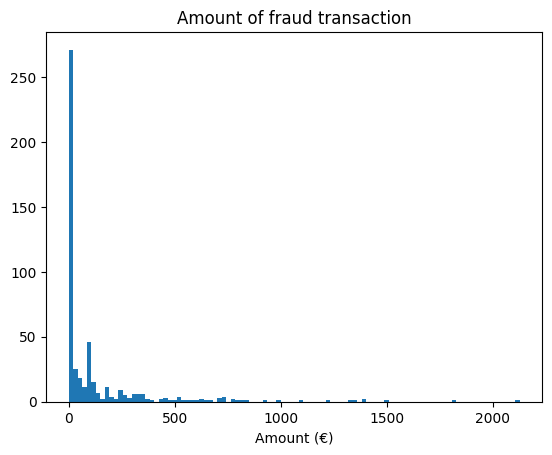

In [107]:
fraud = target == 1
amount_fraud = data["Amount"][fraud]
_, ax = plt.subplots()
ax.hist(amount_fraud, bins=100)
ax.set_title("Amount of fraud transaction")
_ = ax.set_xlabel("Amount (€)")

# b. Addressing the problem with a business metric

we create the business metric that depends on the amount of each transaction. We define the cost matrix similarly to [2]. Accepting a legitimate transaction provides a gain of 2% of the amount of the transaction. However, accepting a fraudulent transaction result in a loss of the amount of the transaction. As stated in [2], the gain and loss related to refusals (of fraudulent and legitimate transactions) are not trivial to define. Here, we define that a refusal of a legitimate transaction is estimated to a loss of 5€ while the refusal of a fraudulent transaction is estimated to a gain of 50€ and the amount of the transaction. Therefore, we define the following function to compute the total benefit of a given decision:

In [108]:
def business_metric(y_true, y_pred, amount):
    mask_true_positive = (y_true == 1) & (y_pred == 1)
    mask_true_negative = (y_true == 0) & (y_pred == 0)
    mask_false_positive = (y_true == 0) & (y_pred == 1)
    mask_false_negative = (y_true == 1) & (y_pred == 0)
    fraudulent_refuse = (mask_true_positive.sum() * 50) + amount[
        mask_true_positive
    ].sum()
    fraudulent_accept = -amount[mask_false_negative].sum()
    legitimate_refuse = mask_false_positive.sum() * -5
    legitimate_accept = (amount[mask_true_negative] * 0.02).sum()
    return fraudulent_refuse + fraudulent_accept + legitimate_refuse + legitimate_accept

In [109]:
sklearn.set_config(enable_metadata_routing=True)
business_scorer = make_scorer(business_metric).set_score_request(amount=True)

So at this stage, we observe that the amount of the transaction is used twice: once as a feature to train our predictive model and once as a metadata to compute the the business metric and thus the statistical performance of our model. When used as a feature, we are only required to have a column in data that contains the amount of each transaction. To use this information as metadata, we need to have an external variable that we can pass to the scorer or the model that internally routes this metadata to the scorer. So let’s create this variable.

In [111]:
amount = credit_card.frame["Amount"].to_numpy()

In [112]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test, amount_train, amount_test = (
    train_test_split(
        data, target, amount, stratify=target, test_size=0.5, random_state=42
    )
)

In [113]:
from sklearn.dummy import DummyClassifier

easy_going_classifier = DummyClassifier(strategy="constant", constant=0)
easy_going_classifier.fit(data_train, target_train)
benefit_cost = business_scorer(
    easy_going_classifier, data_test, target_test, amount=amount_test
)
print(f"Benefit/cost of our easy-going classifier: {benefit_cost:,.2f}€")

Benefit/cost of our easy-going classifier: 221,445.07€


A classifier that predict all transactions as legitimate would create a profit of around 220,000.€ We make the same evaluation for a classifier that predicts all transactions as fraudulent.

In [114]:
intolerant_classifier = DummyClassifier(strategy="constant", constant=1)
intolerant_classifier.fit(data_train, target_train)
benefit_cost = business_scorer(
    intolerant_classifier, data_test, target_test, amount=amount_test
)
print(f"Benefit/cost of our intolerant classifier: {benefit_cost:,.2f}€")

Benefit/cost of our intolerant classifier: -668,903.24€


Such a classifier create a loss of around 670,000.€ A predictive model should allow us to make a profit larger than 220,000.€ It is interesting to compare this business metric with another “standard” statistical metric such as the balanced accuracy.

In [115]:
from sklearn.metrics import get_scorer

balanced_accuracy_scorer = get_scorer("balanced_accuracy")
print(
    "Balanced accuracy of our easy-going classifier: "
    f"{balanced_accuracy_scorer(easy_going_classifier, data_test, target_test):.3f}"
)
print(
    "Balanced accuracy of our intolerant classifier: "
    f"{balanced_accuracy_scorer(intolerant_classifier, data_test, target_test):.3f}"
)

Balanced accuracy of our easy-going classifier: 0.500
Balanced accuracy of our intolerant classifier: 0.500


This is not a surprise that the balanced accuracy is at 0.5 for both classifiers. However, we need to be careful in the rest of the evaluation: we potentially can obtain a model with a decent balanced accuracy that does not make any profit. In this case, the model would be harmful for our business.

# c. create a predictive model using a logistic regression without tuning the decision threshold

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {"logisticregression__C": np.logspace(-6, 6, 13)}
model = GridSearchCV(logistic_regression, param_grid, scoring="neg_log_loss").fit(
    data_train, target_train
)

print(
    "Benefit/cost of our logistic regression: "
    f"{business_scorer(model, data_test, target_test, amount=amount_test):,.2f}€"
)
print(
    "Balanced accuracy of our logistic regression: "
    f"{balanced_accuracy_scorer(model, data_test, target_test):.3f}"
)

Benefit/cost of our logistic regression: 260,787.21€
Balanced accuracy of our logistic regression: 0.815


By observing the balanced accuracy, we see that our predictive model is learning some associations between the features and the target. The business metric also shows that our model is beating the baseline in terms of profit and it would be already beneficial to use it instead of ignoring the fraud detection problem.

# d. Tuning the decision threshold

Now the question is: is our model optimum for the type of decision that we want to do? Up to now, we did not optimize the decision threshold. We use the TunedThresholdClassifierCV to optimize the decision given our business scorer. To avoid a nested cross-validation, we will use the best estimator found during the previous grid-search.

In [117]:
tuned_model = TunedThresholdClassifierCV(
    estimator=model.best_estimator_,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)

In [118]:
tuned_model.fit(data_train, target_train, amount=amount_train)

TunedThresholdClassifierCV(estimator=Pipeline(steps=[('standardscaler',
                                                      StandardScaler()),
                                                     ('logisticregression',
                                                      LogisticRegression(C=100.0))]),
                           n_jobs=2,
                           scoring=make_scorer(business_metric, response_method='predict'))

In [119]:
print(
    "Benefit/cost of our logistic regression: "
    f"{business_scorer(tuned_model, data_test, target_test, amount=amount_test):,.2f}€"
)
print(
    "Balanced accuracy of our logistic regression: "
    f"{balanced_accuracy_scorer(tuned_model, data_test, target_test):.3f}"
)

Benefit/cost of our logistic regression: 268,847.31€
Balanced accuracy of our logistic regression: 0.898


We observe that tuning the decision threshold increases the expected profit of deploying our model as estimated by the business metric. Eventually, the balanced accuracy also increased. Note that it might not always be the case because the statistical metric is not necessarily a surrogate of the business metric. It is therefore important, whenever possible, optimize the decision threshold with respect to the business metric.

# e. Manually setting the decision threshold instead of tuning it

In the previous example, we used the TunedThresholdClassifierCV to find the optimal decision threshold. However, in some cases, we might have some prior knowledge about the problem at hand and we might be happy to set the decision threshold manually.

The class FixedThresholdClassifier allows us to manually set the decision threshold. At prediction time, it behave as the previous tuned model but no search is performed during the fitting process.

Here, we will reuse the decision threshold found in the previous section to create a new model and check that it gives the same results.

In [120]:
from sklearn.model_selection import FixedThresholdClassifier

model_fixed_threshold = FixedThresholdClassifier(
    estimator=model, threshold=tuned_model.best_threshold_
).fit(data_train, target_train)

In [121]:
business_score = business_scorer(
    model_fixed_threshold, data_test, target_test, amount=amount_test
)
print(f"Benefit/cost of our logistic regression: {business_score:,.2f}€")
print(
    "Balanced accuracy of our logistic regression: "
    f"{balanced_accuracy_scorer(model_fixed_threshold, data_test, target_test):.3f}"
)

Benefit/cost of our logistic regression: 268,847.31€
Balanced accuracy of our logistic regression: 0.898


We observe that we obtained the exact same results but the fitting process was much faster since we did not perform any search.